In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [2]:
def percent_scaling(series):
    return (series / 100)

def cpu_scaling(series):
    return (series * 4 / 100)

def single_cpu_scaling(series):
    return (((series - 100) * (-1)) / 100)

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

k = 251

In [3]:
cpu_df = pd.read_csv('../results/numa-matrix.csv')

cpu_df['cache_hit_rate_0'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_0']) / cpu_df['cache_hit_0']
cpu_df['cache_hit_rate_1'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_1']) / cpu_df['cache_hit_1']
cpu_df['cache_hit_rate_2'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_2']) / cpu_df['cache_hit_2']
cpu_df['cache_hit_rate_3'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_3']) / cpu_df['cache_hit_3']

cpu_df['br_miss_rate_0'] = cpu_df['br_miss_0'] / cpu_df['br_insns_0']
cpu_df['br_miss_rate_1'] = cpu_df['br_miss_1'] / cpu_df['br_insns_1']
cpu_df['br_miss_rate_2'] = cpu_df['br_miss_2'] / cpu_df['br_insns_2']
cpu_df['br_miss_rate_3'] = cpu_df['br_miss_3'] / cpu_df['br_insns_3']

cpu_df['insns_0_norm'] = cpu_df['insns_0'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['insns_1_norm'] = cpu_df['insns_1'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['insns_2_norm'] = cpu_df['insns_2'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['insns_3_norm'] = cpu_df['insns_3'] / (cpu_df['time'] - cpu_df['time'].shift())

cpu_df['cycles_0_norm'] = cpu_df['cpu_cycles_0'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['cycles_1_norm'] = cpu_df['cpu_cycles_1'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['cycles_2_norm'] = cpu_df['cpu_cycles_2'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['cycles_3_norm'] = cpu_df['cpu_cycles_3'] / (cpu_df['time'] - cpu_df['time'].shift())

cpu_df['bus_cycles_0_norm'] = cpu_df['bus_cycles_0'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['bus_cycles_1_norm'] = cpu_df['bus_cycles_1'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['bus_cycles_2_norm'] = cpu_df['bus_cycles_2'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['bus_cycles_3_norm'] = cpu_df['bus_cycles_3'] / (cpu_df['time'] - cpu_df['time'].shift())

cpu_df['rd_ios_norm'] = 0
cpu_df['wr_ios_norm'] = 0

cpu_df = cpu_df.drop(index=0)
cpu_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cycles_0_norm,cycles_1_norm,cycles_2_norm,cycles_3_norm,bus_cycles_0_norm,bus_cycles_1_norm,bus_cycles_2_norm,bus_cycles_3_norm,rd_ios_norm,wr_ios_norm
1,2691,1.944,41410,17962,6689,49,1839,269,12316,1000000,...,25.327217,12.444037,12.626300,158.864832,7.532722,1.034862,1.038532,76.791437,0,0
2,4241,1.944,34196,15660,5781,47,1506,217,8640,1000000,...,22.061935,12.914839,12.829032,154.643871,5.574194,1.056129,1.049677,74.635484,0,0
3,5791,1.944,34102,15662,5788,47,1504,215,8694,1000000,...,22.001290,12.957419,12.906452,156.245806,5.609032,1.050968,1.052258,75.425161,0,0
4,7334,1.944,34136,15662,5786,43,1506,212,8704,1000000,...,22.123137,12.993519,13.057032,155.742061,5.640959,1.053143,1.070642,75.187946,0,0
5,8921,1.696,39433,18766,6861,46,1889,266,11450,1000000,...,24.847511,12.565848,12.634531,149.550095,7.214871,1.029616,1.052930,72.163831,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44534,85867080,2.124,385838,281251,104991,1052,71448,1853,188760,1000000,...,248.767247,14.061896,13.968407,14.156673,121.702128,1.186331,1.171502,1.225016,0,0
44535,85868638,1.864,383606,280188,104460,1042,71309,1760,187630,1000000,...,246.216945,14.043646,14.057766,14.080873,120.430039,1.194480,1.174583,1.209243,0,0
44536,85870213,1.864,384577,281824,104941,1030,72172,1799,188162,1000000,...,244.175873,13.948571,13.930159,14.396825,119.467937,1.199365,1.185397,1.194286,0,0
44537,85871770,1.864,380460,278786,103895,997,71127,1737,186062,1000000,...,244.354528,14.038536,14.021837,14.077071,119.500321,1.191394,1.181118,1.204239,0,0


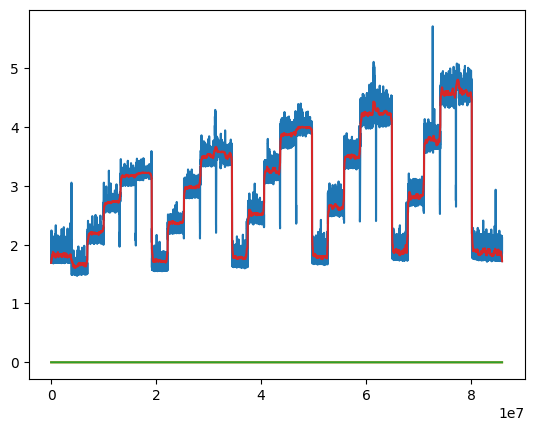

In [4]:
plt.plot(cpu_df['time'], cpu_df['current'])
plt.plot(cpu_df['time'], cpu_df['rd_ios_norm'] * 10000)
plt.plot(cpu_df['time'], cpu_df['wr_ios_norm'] * 10000)
plt.plot(cpu_df['time'], signal.medfilt(cpu_df['current'], kernel_size=k))
plt.tick_params(axis='x', which='both', top=False)

In [5]:
mem_df = pd.read_csv('../results/disk-copy.csv')

mem_df['cache_hit_rate_0'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_0']) / mem_df['cache_hit_0']
mem_df['cache_hit_rate_1'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_1']) / mem_df['cache_hit_1']
mem_df['cache_hit_rate_2'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_2']) / mem_df['cache_hit_2']
mem_df['cache_hit_rate_3'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_3']) / mem_df['cache_hit_3']

mem_df['br_miss_rate_0'] = mem_df['br_miss_0'] / mem_df['br_insns_0']
mem_df['br_miss_rate_1'] = mem_df['br_miss_1'] / mem_df['br_insns_1']
mem_df['br_miss_rate_2'] = mem_df['br_miss_2'] / mem_df['br_insns_2']
mem_df['br_miss_rate_3'] = mem_df['br_miss_3'] / mem_df['br_insns_3']

mem_df['insns_0_norm'] = mem_df['insns_0'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['insns_1_norm'] = mem_df['insns_1'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['insns_2_norm'] = mem_df['insns_2'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['insns_3_norm'] = mem_df['insns_3'] / (mem_df['time'] - mem_df['time'].shift())

mem_df['cycles_0_norm'] = mem_df['cpu_cycles_0'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['cycles_1_norm'] = mem_df['cpu_cycles_1'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['cycles_2_norm'] = mem_df['cpu_cycles_2'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['cycles_3_norm'] = mem_df['cpu_cycles_3'] / (mem_df['time'] - mem_df['time'].shift())

mem_df['bus_cycles_0_norm'] = mem_df['bus_cycles_0'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['bus_cycles_1_norm'] = mem_df['bus_cycles_1'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['bus_cycles_2_norm'] = mem_df['bus_cycles_2'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['bus_cycles_3_norm'] = mem_df['bus_cycles_3'] / (mem_df['time'] - mem_df['time'].shift())

mem_df['rd_ios_norm'] = mem_df['rd_ios'] * 1000 / (mem_df['time'] - mem_df['time'].shift())
mem_df['wr_ios_norm'] = mem_df['wr_ios'] * 1000 / (mem_df['time'] - mem_df['time'].shift())

mem_df = mem_df.drop(index=0)
mem_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cycles_0_norm,cycles_1_norm,cycles_2_norm,cycles_3_norm,bus_cycles_0_norm,bus_cycles_1_norm,bus_cycles_2_norm,bus_cycles_3_norm,rd_ios_norm,wr_ios_norm
1,3578,2.356,38565,17353,6437,64,1679,256,10786,800000,...,18.320665,170.819477,9.838480,13.941093,5.123990,83.354394,0.809026,3.538717,0.0,0.0
2,5601,2.356,35086,14895,5497,66,1347,222,9098,800000,...,17.343549,167.274839,10.042511,63.458230,4.497281,81.559565,0.840336,27.551162,0.0,0.0
3,7673,2.356,33733,15463,5721,43,1446,216,8456,800000,...,16.280405,162.790541,9.703185,28.616313,4.081081,79.364382,0.818050,10.226351,0.0,0.0
4,9695,1.512,36793,16519,6084,61,1565,229,9403,800000,...,18.196340,168.815529,10.208210,10.115232,4.650346,82.334817,0.863501,0.825915,0.0,0.0
5,11698,1.512,35629,17133,6121,52,1591,221,9114,800000,...,17.787818,167.281578,9.976535,10.000999,4.550175,81.552671,0.804294,0.821767,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28111,53719538,1.716,31872,14615,5291,41,1278,167,6713,1000000,...,19.517453,211.067973,13.513166,13.524189,4.110839,102.981629,1.094917,1.082058,0.0,0.0
28112,53721169,1.716,31587,15312,5342,39,1303,174,6671,1000000,...,19.366646,207.817903,13.480074,13.443286,4.090129,101.313305,1.129982,1.147762,0.0,0.0
28113,53722796,1.860,31251,14617,5288,38,1278,168,6494,1000000,...,19.207744,206.054702,13.470191,13.490473,3.991395,100.435157,1.091580,1.144438,0.0,0.0
28114,53724427,1.860,31414,14618,5293,39,1284,166,6560,1000000,...,19.260576,205.462293,13.474555,13.478847,4.022072,100.136726,1.150215,1.123237,0.0,0.0


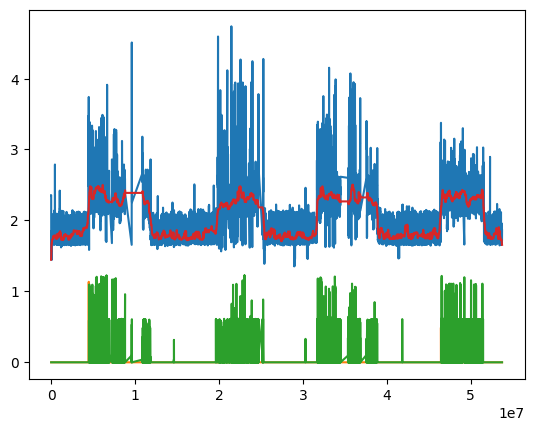

In [6]:
plt.plot(mem_df['time'], mem_df['current'])
plt.plot(mem_df['time'], mem_df['rd_ios_norm'])
plt.plot(mem_df['time'], mem_df['wr_ios_norm'])
plt.plot(mem_df['time'], signal.medfilt(mem_df['current'], kernel_size=k))
plt.tick_params(axis='x', which='both', top=False)

In [7]:
memrate_df = pd.read_csv('../results/disk-memcpy.csv')

memrate_df['cache_hit_rate_0'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_0']) / memrate_df['cache_hit_0']
memrate_df['cache_hit_rate_1'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_1']) / memrate_df['cache_hit_1']
memrate_df['cache_hit_rate_2'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_2']) / memrate_df['cache_hit_2']
memrate_df['cache_hit_rate_3'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_3']) / memrate_df['cache_hit_3']

memrate_df['br_miss_rate_0'] = memrate_df['br_miss_0'] / memrate_df['br_insns_0']
memrate_df['br_miss_rate_1'] = memrate_df['br_miss_1'] / memrate_df['br_insns_1']
memrate_df['br_miss_rate_2'] = memrate_df['br_miss_2'] / memrate_df['br_insns_2']
memrate_df['br_miss_rate_3'] = memrate_df['br_miss_3'] / memrate_df['br_insns_3']

memrate_df['insns_0_norm'] = memrate_df['insns_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_1_norm'] = memrate_df['insns_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_2_norm'] = memrate_df['insns_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_3_norm'] = memrate_df['insns_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['cycles_0_norm'] = memrate_df['cpu_cycles_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_1_norm'] = memrate_df['cpu_cycles_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_2_norm'] = memrate_df['cpu_cycles_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_3_norm'] = memrate_df['cpu_cycles_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['bus_cycles_0_norm'] = memrate_df['bus_cycles_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_1_norm'] = memrate_df['bus_cycles_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_2_norm'] = memrate_df['bus_cycles_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_3_norm'] = memrate_df['bus_cycles_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['rd_ios_norm'] = signal.medfilt(memrate_df['rd_ios'] * 1000 / (memrate_df['time'] - memrate_df['time'].shift()), kernel_size=51)
memrate_df['wr_ios_norm'] = signal.medfilt(memrate_df['wr_ios'] * 1000 / (memrate_df['time'] - memrate_df['time'].shift()), kernel_size=51)

memrate_df = memrate_df.drop(index=0)
memrate_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cycles_0_norm,cycles_1_norm,cycles_2_norm,cycles_3_norm,bus_cycles_0_norm,bus_cycles_1_norm,bus_cycles_2_norm,bus_cycles_3_norm,rd_ios_norm,wr_ios_norm
1,3773,1.812,39801,18468,6715,68,1772,290,11245,800000,...,19.016245,9.643574,146.986144,9.743430,5.372671,0.765886,71.418060,0.770186,0.0,0.0
2,5776,1.812,38566,17922,6671,56,1742,265,10794,800000,...,19.254119,9.915127,143.995007,10.168747,5.388917,0.793809,69.895657,0.837244,0.0,0.0
3,7779,1.812,38330,17924,6664,51,1752,260,10761,800000,...,19.136296,9.952571,144.544184,10.084373,5.372441,0.821767,70.197204,0.830754,0.0,0.0
4,9869,1.476,73279,27393,10850,173,2952,549,28257,800000,...,35.061722,32.265072,169.974641,10.093301,13.520096,12.168421,68.578947,0.835885,0.0,0.0
5,11994,1.476,39007,17884,6665,55,1747,253,11102,800000,...,18.356235,10.011294,139.520000,9.567059,5.224471,0.770353,67.781176,0.782588,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23099,45568192,1.668,31306,14618,5289,41,1281,165,6501,1000000,...,19.135697,13.352689,180.274450,13.446822,3.973716,1.051345,87.577017,1.126528,0.0,0.0
23100,45569846,1.668,33291,15328,5327,53,1295,174,7296,1000000,...,20.127570,13.259371,175.858525,13.342805,4.411125,1.119710,85.412938,1.092503,0.0,0.0
23101,45571474,1.668,31793,14546,5273,49,1277,170,6771,1000000,...,19.528870,13.479730,176.744472,13.480344,4.159091,1.131450,85.799754,1.076781,0.0,0.0
23102,45573100,1.668,31365,15237,5325,46,1295,168,6648,1000000,...,19.289668,13.525215,180.473555,13.526445,4.088561,1.137146,87.664822,1.069496,0.0,0.0


In [8]:
X = pd.concat([cpu_df, mem_df, memrate_df])[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                                             'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                                             'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                                             'rd_ios_norm','wr_ios_norm',
                                             'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y = signal.medfilt(pd.concat([cpu_df, mem_df, memrate_df])['current'], kernel_size=k)

In [9]:
model = RandomForestRegressor(n_estimators=500, n_jobs=-1)
model.fit(X, Y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [22]:
memrate_df = pd.read_csv('../results/disk-fft.csv')

memrate_df['cache_hit_rate_0'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_0']) / memrate_df['cache_hit_0']
memrate_df['cache_hit_rate_1'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_1']) / memrate_df['cache_hit_1']
memrate_df['cache_hit_rate_2'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_2']) / memrate_df['cache_hit_2']
memrate_df['cache_hit_rate_3'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_3']) / memrate_df['cache_hit_3']

memrate_df['br_miss_rate_0'] = memrate_df['br_miss_0'] / memrate_df['br_insns_0']
memrate_df['br_miss_rate_1'] = memrate_df['br_miss_1'] / memrate_df['br_insns_1']
memrate_df['br_miss_rate_2'] = memrate_df['br_miss_2'] / memrate_df['br_insns_2']
memrate_df['br_miss_rate_3'] = memrate_df['br_miss_3'] / memrate_df['br_insns_3']

memrate_df['insns_0_norm'] = memrate_df['insns_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_1_norm'] = memrate_df['insns_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_2_norm'] = memrate_df['insns_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_3_norm'] = memrate_df['insns_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['cycles_0_norm'] = memrate_df['cpu_cycles_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_1_norm'] = memrate_df['cpu_cycles_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_2_norm'] = memrate_df['cpu_cycles_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_3_norm'] = memrate_df['cpu_cycles_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['bus_cycles_0_norm'] = memrate_df['bus_cycles_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_1_norm'] = memrate_df['bus_cycles_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_2_norm'] = memrate_df['bus_cycles_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_3_norm'] = memrate_df['bus_cycles_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['rd_ios_norm'] = signal.medfilt(memrate_df['rd_ios'] * 1000 / (memrate_df['time'] - memrate_df['time'].shift()), kernel_size=51)
memrate_df['wr_ios_norm'] = signal.medfilt(memrate_df['wr_ios'] * 1000 / (memrate_df['time'] - memrate_df['time'].shift()), kernel_size=51)

memrate_df = memrate_df.drop(index=0)
memrate_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cycles_0_norm,cycles_1_norm,cycles_2_norm,cycles_3_norm,bus_cycles_0_norm,bus_cycles_1_norm,bus_cycles_2_norm,bus_cycles_3_norm,rd_ios_norm,wr_ios_norm
1,4769,1.700,71033,18552,6900,71,1771,301,11827,600000,...,25.117751,7.185997,109.594059,7.492928,4.182107,0.568953,53.264144,0.630481,0.0,0.0
2,7409,1.700,38239,17921,6678,49,1743,270,10658,600000,...,14.484470,7.514773,110.497727,7.603788,4.037121,0.604924,53.678030,0.587500,0.0,0.0
3,10036,1.360,28368,13012,4759,42,1147,166,5855,600000,...,10.798630,7.543967,109.619338,7.626570,2.228778,0.572136,53.234107,0.632661,0.0,0.0
4,12772,1.360,85171,28466,11332,546,3380,779,35475,600000,...,31.129751,7.331506,105.552997,7.330775,12.966009,0.595029,51.240863,0.628289,0.0,0.0
5,15198,1.708,40414,17858,6524,84,1751,296,11648,700000,...,16.658697,28.448887,121.093157,8.454246,4.801319,10.816158,58.804204,0.708574,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64402,108964410,1.764,383946,280108,104320,1152,71554,1865,187870,1000000,...,236.419951,13.559113,13.735837,13.559113,115.683498,1.108374,1.162562,1.139163,0.0,0.0
64403,108966041,1.764,384303,280161,104506,1113,71363,1872,187970,1000000,...,235.624157,13.486818,13.527284,13.489884,115.248314,1.074188,1.164929,1.125690,0.0,0.0
64404,108967670,1.764,381951,278920,103926,1118,71170,1844,186821,1000000,...,234.469613,13.508901,13.484346,13.529773,114.684469,1.145488,1.145488,1.138122,0.0,0.0
64405,108969320,1.764,403928,282877,105568,1203,71686,2030,197791,1000000,...,244.804848,13.443636,325.651515,13.275152,119.873333,1.209091,157.209091,1.146667,0.0,0.0


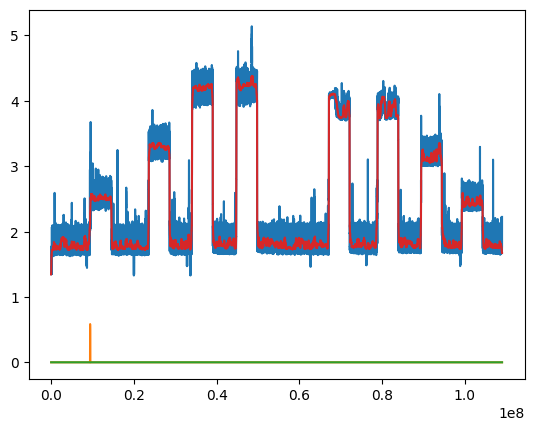

In [11]:
plt.plot(memrate_df['time'], memrate_df['current'])
plt.plot(memrate_df['time'], memrate_df['rd_ios_norm'])
plt.plot(memrate_df['time'], memrate_df['wr_ios_norm'])
plt.plot(memrate_df['time'], signal.medfilt(memrate_df['current'], kernel_size=k))
plt.tick_params(axis='x', which='both', top=False)

In [12]:
X_test = memrate_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = signal.medfilt(memrate_df['current'], kernel_size=k)
predictions = model.predict(X_test)

In [13]:
mean_squared_error(Y_test, predictions)

0.11421135798054846

In [14]:
mean_absolute_error(Y_test, predictions)

0.2048710243145057

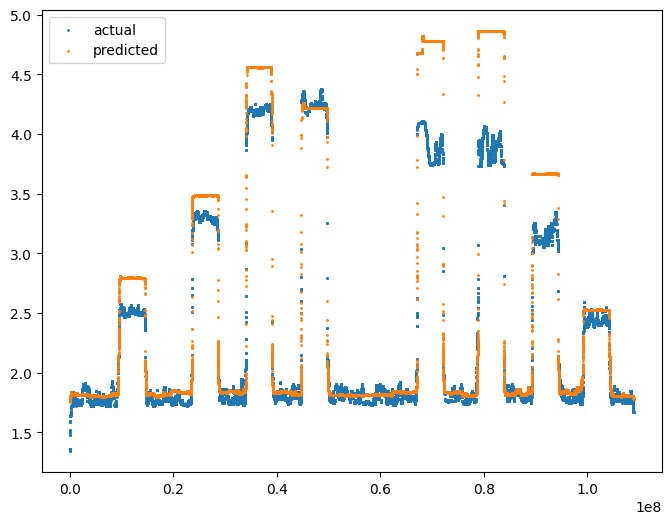

In [15]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.scatter(memrate_df['time'], signal.medfilt(memrate_df['current'], kernel_size=k), label='actual', s=1)
plt.scatter(memrate_df['time'], signal.medfilt(predictions, kernel_size=k), label='predicted', s=1)
plt.legend(loc='upper left')

In [16]:
memrate_df = pd.read_csv('../results/disk-memthrash.csv')

memrate_df['cache_hit_rate_0'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_0']) / memrate_df['cache_hit_0']
memrate_df['cache_hit_rate_1'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_1']) / memrate_df['cache_hit_1']
memrate_df['cache_hit_rate_2'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_2']) / memrate_df['cache_hit_2']
memrate_df['cache_hit_rate_3'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_3']) / memrate_df['cache_hit_3']

memrate_df['br_miss_rate_0'] = memrate_df['br_miss_0'] / memrate_df['br_insns_0']
memrate_df['br_miss_rate_1'] = memrate_df['br_miss_1'] / memrate_df['br_insns_1']
memrate_df['br_miss_rate_2'] = memrate_df['br_miss_2'] / memrate_df['br_insns_2']
memrate_df['br_miss_rate_3'] = memrate_df['br_miss_3'] / memrate_df['br_insns_3']

memrate_df['insns_0_norm'] = memrate_df['insns_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_1_norm'] = memrate_df['insns_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_2_norm'] = memrate_df['insns_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_3_norm'] = memrate_df['insns_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['cycles_0_norm'] = memrate_df['cpu_cycles_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_1_norm'] = memrate_df['cpu_cycles_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_2_norm'] = memrate_df['cpu_cycles_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['cycles_3_norm'] = memrate_df['cpu_cycles_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['bus_cycles_0_norm'] = memrate_df['bus_cycles_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_1_norm'] = memrate_df['bus_cycles_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_2_norm'] = memrate_df['bus_cycles_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['bus_cycles_3_norm'] = memrate_df['bus_cycles_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df['rd_ios_norm'] = signal.medfilt(memrate_df['rd_ios'] / (memrate_df['time'] - memrate_df['time'].shift()), kernel_size=k)
memrate_df['wr_ios_norm'] = signal.medfilt(memrate_df['wr_ios'] / (memrate_df['time'] - memrate_df['time'].shift()), kernel_size=k)

memrate_df = memrate_df.drop(index=0)
memrate_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cycles_0_norm,cycles_1_norm,cycles_2_norm,cycles_3_norm,bus_cycles_0_norm,bus_cycles_1_norm,bus_cycles_2_norm,bus_cycles_3_norm,rd_ios_norm,wr_ios_norm
1,4638,1.568,38813,17185,6452,61,1688,286,11971,600000,...,14.227639,7.406525,112.349707,7.601173,4.388196,0.606672,54.611804,0.647727,0.0,0.0
2,7257,1.568,42230,19734,7385,55,1941,301,12666,600000,...,16.124475,7.616266,110.107293,7.691103,4.836197,0.627339,53.437953,0.624284,0.0,0.0
3,9938,1.380,64461,27081,10638,170,2717,497,23983,600000,...,24.043640,25.044013,120.924282,17.946289,8.945543,9.395748,58.891458,5.850429,0.0,0.0
4,12559,1.380,38534,18365,6717,52,1771,257,10923,600000,...,14.702022,7.715376,110.403663,7.628768,4.167493,0.649752,53.605494,0.621137,0.0,0.0
5,15193,1.620,37793,17912,6670,46,1741,248,10484,600000,...,14.348140,7.560364,110.341306,7.547836,3.980258,0.627942,53.579347,0.563402,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19337,35068720,1.776,31471,14536,5276,39,1272,162,6562,1000000,...,19.342963,13.483712,13.510756,154.841426,4.033190,1.153042,1.180086,74.860479,0.0,0.0
19338,35070590,1.960,31662,14536,5276,44,1278,164,6646,1000000,...,16.931551,11.912834,11.854011,133.000535,3.554011,1.091979,1.023529,64.287701,0.0,0.0
19339,35072212,1.960,31406,14535,5273,43,1269,163,6525,1000000,...,19.362515,13.615290,13.675092,150.178792,4.022811,1.154747,1.185573,72.471640,0.0,0.0
19340,35073841,1.960,31340,14535,5257,41,1274,161,6508,1000000,...,19.238797,13.486802,13.585635,150.385513,3.995089,1.162063,1.169429,72.647637,0.0,0.0


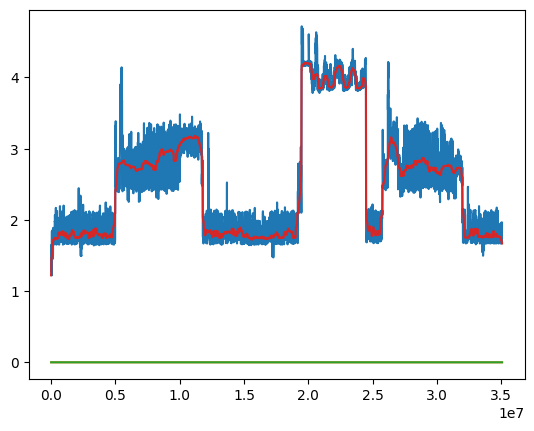

In [17]:
plt.plot(memrate_df['time'], memrate_df['current'])
plt.plot(memrate_df['time'], memrate_df['rd_ios_norm'] * 1000)
plt.plot(memrate_df['time'], memrate_df['wr_ios_norm'] * 1000)
plt.plot(memrate_df['time'], signal.medfilt(memrate_df['current'], kernel_size=k))
plt.tick_params(axis='x', which='both', top=False)

In [18]:
X_test = memrate_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = signal.medfilt(memrate_df['current'], kernel_size=k)
predictions = model.predict(X_test)

In [19]:
mean_squared_error(Y_test, predictions)

0.15967497887739515

In [20]:
mean_absolute_error(Y_test, predictions)

0.27163302662737177

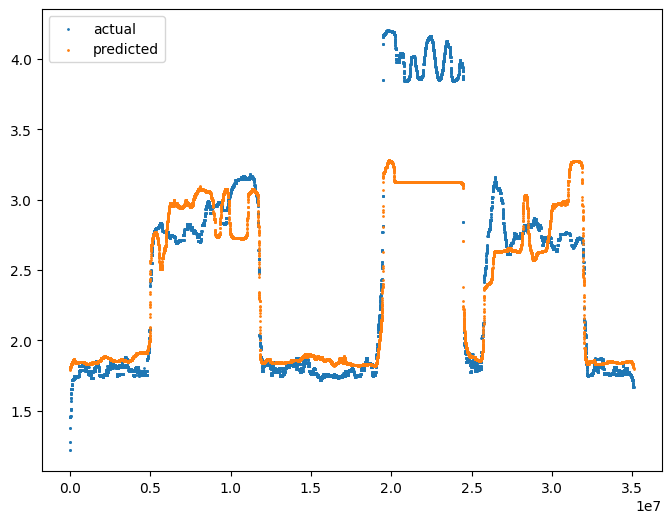

In [21]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.scatter(memrate_df['time'], signal.medfilt(memrate_df['current'], kernel_size=k), label='actual', s=1)
plt.scatter(memrate_df['time'], signal.medfilt(predictions, kernel_size=k), label='predicted', s=1)
plt.legend(loc='upper left')